# Modeling full data

Since our full data has many features due to node embeddings, we need to use robust models as XGBoost, Support Vector Machine and a Neural Network. The metric chosen metric for this evaluation is F1-Score because both classes have the same weight

## Preparing environment

In [15]:
import pandas as pd
import numpy as np
import sys
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import optuna
sys.path.append('../high_performance_employee_resign_prediction')
from utils import paths

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importing data

In [2]:
train_df = pd.read_csv(paths.data_processed_dir('train_processed.csv'))
test_df = pd.read_csv(paths.data_processed_dir('test_processed.csv'))

In [3]:
# Saving id_employee_employee for submission

id_col = test_df['id_employee']

In [4]:
y = train_df['resign']

In [5]:
# Dropping unnecessary columns

X = train_df.drop(columns=['id_employee', 'id_last_boss', 'resign'])
X_test = test_df.drop(columns=['id_employee', 'id_last_boss'])

## Preparing cross validation

In [6]:
# Folding data

kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Evaluating XGBoost Model

In [7]:
# Creating base model

xgb_base = XGBClassifier(random_state=42, eval_metric='mlogloss')

In [8]:
# Making cross-validation in xgboost

cv_results = cross_val_score(xgb_base, X, y, cv=kf, scoring='f1')
cv_results

array([0.71258907, 0.72533333, 0.68085106, 0.69021739, 0.72682927])

Initial f1 results are good, let's optimize the model with cross-validation

In [9]:
# Defining param grid

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}

In [12]:
# Defining random search

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    scoring=make_scorer(f1_score),
    n_iter=100,  # Number of different combinations to try
    cv=kf,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [13]:
# Optimizing model

random_search.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_t...
                                           random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring=make_scorer(f1_score), verbose=2)

In [14]:
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation F1 score: {random_search.best_score_}")

Best parameters found: {'subsample': 0.9, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.7}
Best cross-validation F1 score: 0.7312546621631444


# Evaluating and optimizing neural network

In [20]:
X_train_tensor = torch.from_numpy(X.to_numpy()).float()
X_test_tensor = torch.from_numpy(X_test.to_numpy()).float()
y_tensor = torch.from_numpy(y.to_numpy()).long()

In [21]:
# Defining Neural Network

class Net(nn.Module):
    def __init__(self, input_size, num_classes, num_layers, hidden_size, dropout_rate, activation_fn):
        super(Net, self).__init__()
        layers = []
        in_size = input_size
        
        for _ in range(num_layers):
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(activation_fn)
            layers.append(nn.Dropout(dropout_rate))
            in_size = hidden_size
        
        layers.append(nn.Linear(in_size, num_classes))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

## Defining function to optimize with Optuna

In [22]:
# Defining objective function

def objective(trial):
    # Hyperparameters to tune
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 32, 256, log=True)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU'])

    # Choose activation function
    if activation_name == 'ReLU':
        activation_fn = nn.ReLU()
    elif activation_name == 'LeakyReLU':
        activation_fn = nn.LeakyReLU()
    else:
        activation_fn = nn.ELU()
        
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    

    for train_index, val_index in skf.split(X_train_tensor, y_tensor):
        X_train_fold = X_train_tensor[train_index]
        y_train_fold = y_tensor[train_index]
        X_val_fold = X_train_tensor[val_index]
        y_val_fold = y_tensor[val_index]

        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        val_dataset = TensorDataset(X_val_fold, y_val_fold)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        model = Net(input_size=X_train_tensor.shape[1],
                    num_classes=2,
                    num_layers=num_layers,
                    hidden_size=hidden_size,
                    dropout_rate=dropout_rate,
                    activation_fn=activation_fn)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Early stopping parameters
        best_val_f1 = 0
        patience = 10
        trigger_times = 0

        for epoch in range(50):  # Max epochs
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs.data, 1)
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(y_batch.cpu().numpy())

            val_f1 = f1_score(all_labels, all_preds, average='binary')

            # Early stopping check
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    break  # Early stopping

        f1_scores.append(best_val_f1)

    # Return the average F1-score across folds
    return np.mean(f1_scores)

In [25]:
# Optimizing hyperparameters:

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-09-09 21:11:36,571] A new study created in memory with name: no-name-c65e3061-07cd-4e04-850d-54cb5c58e023
[I 2024-09-09 21:11:50,561] Trial 0 finished with value: 0.6902391846715231 and parameters: {'num_layers': 2, 'hidden_size': 145, 'dropout_rate': 0.2454372610719735, 'weight_decay': 0.00369785660649159, 'learning_rate': 0.00042385504244294515, 'batch_size': 128, 'activation': 'LeakyReLU'}. Best is trial 0 with value: 0.6902391846715231.
[I 2024-09-09 21:11:58,823] Trial 1 finished with value: 0.7119349949036824 and parameters: {'num_layers': 2, 'hidden_size': 38, 'dropout_rate': 0.18757412544246674, 'weight_decay': 0.00017526556743193298, 'learning_rate': 0.015277778465500944, 'batch_size': 64, 'activation': 'LeakyReLU'}. Best is trial 1 with value: 0.7119349949036824.
[I 2024-09-09 21:12:14,358] Trial 2 finished with value: 0.7341018370103333 and parameters: {'num_layers': 2, 'hidden_size': 38, 'dropout_rate': 0.4715125534118684, 'weight_decay': 0.0005168237257752334, 'lea

In [26]:
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Best hyperparameters:
  num_layers: 1
  hidden_size: 73
  dropout_rate: 0.20765536980835012
  weight_decay: 0.00013877547984341825
  learning_rate: 0.0036580686692554436
  batch_size: 128
  activation: ELU


## Evaluating best models

### XGBoost

In [28]:
xgb_params = random_search.best_params_

In [29]:
best_xgboost = XGBClassifier(random_state=42, eval_metric='mlogloss',
                             **xgb_params)

In [30]:
# Fitting the model 

best_xgboost.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [31]:
# Predicting values

y_pred_xgb = best_xgboost.predict(X_test)

In [33]:
# Saving predicted values

sub_xgb = pd.DataFrame(y_pred_xgb, columns=['abandono_6meses'])
sub_xgb = pd.concat([id_col, sub_xgb], axis=1)
sub_xgb.rename(columns={'id_employee': 'ID'}, inplace=True)
sub_xgb.to_csv('../results/sub_xgb_full.csv', index=False, sep=',')

Kaggle Score:

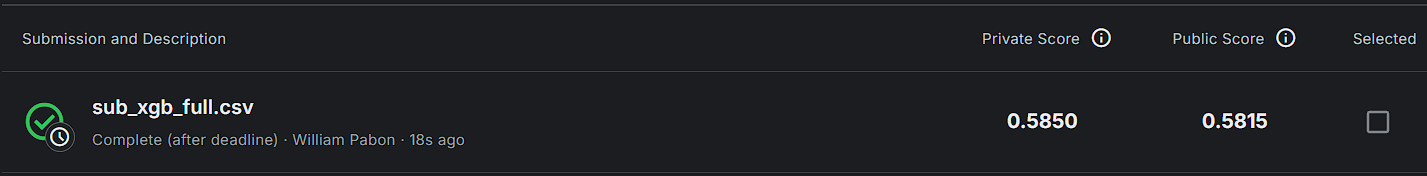

In [35]:
study.best_params

{'num_layers': 1,
 'hidden_size': 73,
 'dropout_rate': 0.20765536980835012,
 'weight_decay': 0.00013877547984341825,
 'learning_rate': 0.0036580686692554436,
 'batch_size': 128,
 'activation': 'ELU'}

### Neural Network

In [37]:
# Use the entire training set
train_dataset = TensorDataset(X_train_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Initialize the model with best hyperparameters
model = Net(input_size=X_train_tensor.shape[1],
            num_classes=2,
            num_layers=best_params['num_layers'],
            hidden_size=best_params['hidden_size'],
            dropout_rate=best_params['dropout_rate'],
            activation_fn=nn.ELU())

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

# Train the model
for epoch in range(50):  # Adjust epochs as needed
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

In [38]:
# Loading test data
test_loader = DataLoader(X_test_tensor, batch_size=best_params['batch_size'])

# Evaluation
model.eval()
nn_pred = []

with torch.no_grad():
    for X_batch in test_loader:
        # Getting outputs
        outputs = model(X_batch)
        
        # Get the predicted class (0 or 1)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append the predicted class to test_predictions
        nn_pred.extend(predicted.cpu().numpy())

In [41]:
# Saving predicted values

sub_nn = pd.DataFrame(nn_pred, columns=['abandono_6meses'])
sub_nn = pd.concat([id_col, sub_nn], axis=1)
sub_nn.rename(columns={'id_employee': 'ID'}, inplace=True)
sub_nn.to_csv('../results/sub_nn_full.csv', index=False, sep=',')

Kaggle Score:

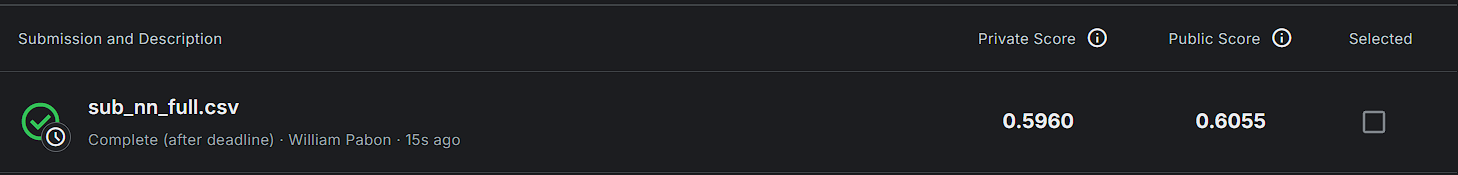